# Refining the Optimizer
> All is one

We're going to replace the Pytorch Optim with a custom optimizer class that uses `steppers`.

This will allow us to make one Optimizer that can do any type of step we want to define. 

It can do a SGD step, a momentum step, a weight decay step, or an Adam step. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_09a import *

## Imagenette Data & Baseline Model

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160) # downloads and returns a path to folder
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor] # transforms to be applied to images
bs = 128
il = ImageList.from_files(path, tfms=tfms) # Imagelist of filenames from path
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name="val")) # Splitdata by folder function
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcesser()) # label the data by parent folder
data = ll.to_databunch(bs, c_in=3, c_out=10)

In [4]:
nfs = [32,64,128,256]

In [5]:
callbacks = [partial(AvgStatsCallback, accuracy),
            CudaCallback, 
            partial(BatchTransformXCallback, norm_imagenette)]

In [6]:
learn, run = get_learn_run(data, nfs,conv_layer, 0.3,  cbs=callbacks)

In [7]:
run.fit(1, learn)

train: [1.7565843971116275, tensor(0.3893, device='cuda:0')]
valid: [1.6632195461783439, tensor(0.4364, device='cuda:0')]


Our baseline model using vanilla SGD gives us around 45% validation accuracy in one epoch. 

In [8]:
run.fit(8, learn)

train: [1.319560044619284, tensor(0.5630, device='cuda:0')]
valid: [1.3284424761146496, tensor(0.5575, device='cuda:0')]
train: [1.03668477812467, tensor(0.6612, device='cuda:0')]
valid: [1.4276872263136942, tensor(0.5320, device='cuda:0')]
train: [0.8317880633514627, tensor(0.7274, device='cuda:0')]
valid: [1.3523896546576433, tensor(0.5674, device='cuda:0')]
train: [0.6142635879250713, tensor(0.8037, device='cuda:0')]
valid: [1.3932671924761146, tensor(0.5916, device='cuda:0')]
train: [0.42345117538150806, tensor(0.8688, device='cuda:0')]
valid: [1.3458276522691084, tensor(0.6166, device='cuda:0')]
train: [0.26514520140557346, tensor(0.9211, device='cuda:0')]
valid: [1.4726103453423567, tensor(0.5924, device='cuda:0')]
train: [0.12024039227099614, tensor(0.9749, device='cuda:0')]
valid: [1.4713951781449044, tensor(0.6097, device='cuda:0')]
train: [0.05983125729147415, tensor(0.9910, device='cuda:0')]
valid: [1.4784240644904458, tensor(0.6283, device='cuda:0')]


If we train it a bit further we are up to 62% validation accuracy.

## SGD

We're going to stop using the Pytorch `optim` and write an SGD optimizer from scratch. 

Then we'll take this basic optimizer structure and iterate on it to add different regularization and optimization algorithms.

### Optimizer class v1

The `Optimizer` class at its core will store a dictionary of parameters and hyper-parameters and apply a function to the parameters using the hyperparameters and some `stepper` function when `step` is called after each batch . 

Parameters will be stored in `param_groups` which is a list of lists:

``` python
self.param_groups = [[pg1], [pg2], [pg3]]
    
```    
And each `param_group` will have a corresponding hyper-parameter dictionary in the list `self.hyper`:
``` python
self.hyper = [{'lr': 0.2,'wd':0.}, {'lr': 0.1,'wd':0.}, {'lr': 0.4,'wd':0.}]
``` 

In [9]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.param_groups = list(params)
        
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): 
            self.param_groups = [self.param_groups]
        
        self.hypers = [{**defaults} for p in self.param_groups]
        self.steppers = listify(steppers)
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers) for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p,hyper in self.grad_params(): # iterates through 
            p.grad.detach_() # removes gradient computation history
            p.grad.zero_() # zeros the grads for next batch
            
    def step(self):
        for p, hyper in self.grad_params(): # does nothing without steppers
            compose(p, self.steppers, **hyper)

### SGD stepper

Takes `p` a parameter and the `lr` hyperparameter, a scalar, and adds the gradient of the parameter multiplied by the negative learning rate.

In [10]:
#export
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

In [11]:
opt_func = partial(Optimizer, steppers=[sgd_step])

### Refactor Callbacks

We'll need to refactor some of our callbacks to work with the new optimzer

In [12]:
#export
class AvgStats():
    def __init__(self, metrics, in_train):
        self.metrics = listify(metrics)
        self.in_train = in_train

    def reset(self):
        self.tot_loss = 0.
        self.count = 0
        self.tot_mets = [0.]*len(self.metrics)

    @property
    def all_stats(self): 
        return [self.tot_loss.item()] + [o.item() for o in self.tot_mets]
    
    @property
    def avg_stats(self): 
        return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return "Something went wrong: count is zero."
        if self.in_train:
            return f"Train: {[round(o,4) for o in self.avg_stats]}" 
        else:
            return f"Valid: {[round(o,4) for o in self.avg_stats]}\n"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i, m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats = AvgStats(metrics, True)
        self.valid_stats = AvgStats(metrics, False)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad():
            stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

`Recorder` will have to be re-written to work with this new optimizer. We had been pulling everything from Pytorch's `opt.param_groups`.

Now to get the learning rate we access `self.opt.hypers`

In [13]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.losses = []
        self.lrs = []

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())

    def plot_loss(self): plt.plot(self.losses)
    def plot_lr  (self): plt.plot(self.lrs)

    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

The `ParamScheduler` now needs to go through all of our `self.opt.hypers` and apply its scheduler functions accordingly. 

Remember each Param we schedule gets a different `ParamScheduler` callback - so each one is only accessing one `self.pname` in `self.opt.hypers` at a time. 

In [14]:
#export
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs):
        self.pname = pname
        self.sched_funcs = listify(sched_funcs)

    def begin_batch(self):
        if not self.in_train: return # end if not in train mode
        fs = self.sched_funcs # list of scheduler funcs
        if len(fs)==1: # if only 1 scheduler multiple it and use it for each group
            fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs # position in training
        for scheduler, hyper in zip(fs, self.opt.hypers):
            hyper[self.pname] = scheduler(pos) # change the pname according to the scheduler
            

Similarly, the `LR_Find` now needs to use `opt.param_groups`

In [15]:
#export
class LR_Find(Callback):
    _order = 1

    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter = max_iter
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.best_loss = 1e9

    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr # change from opt.param_groups
 
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException
        if self.loss < self.best_loss:
            self.best_loss = self.loss

### SGD Test

In [16]:
sched = combine_scheds([.3, .7], [sched_cos(.3, .6), sched_lin(.6, 0.2)])

In [17]:
callbacks = [partial(AvgStatsCallback, accuracy),
             CudaCallback, Recorder, 
             partial(ParamScheduler, 'lr', sched)]

In [18]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.3,  cbs=callbacks, opt_func=opt_func)

In [19]:
run.fit(1, learn)

Train: [1.8129, 0.3741]
Valid: [1.5118, 0.4856]



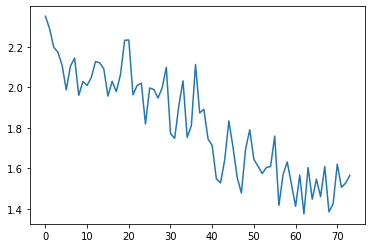

In [20]:
run.recorder.plot_loss()

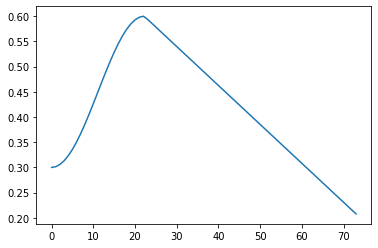

In [21]:
run.recorder.plot_lr()

In [22]:
run.fit(8, learn)

Train: [1.3324, 0.554]
Valid: [1.6937, 0.453]

Train: [1.2083, 0.5976]
Valid: [1.5231, 0.5292]

Train: [1.002, 0.6698]
Valid: [1.333, 0.5839]

Train: [0.6864, 0.7737]
Valid: [1.596, 0.5445]

Train: [0.4136, 0.8687]
Valid: [1.4621, 0.5768]

Train: [0.1873, 0.9516]
Valid: [1.3468, 0.6189]

Train: [0.0729, 0.9898]
Valid: [1.3567, 0.6285]

Train: [0.0355, 0.9975]
Valid: [1.3398, 0.6532]



We get about the same validation accuracy. 

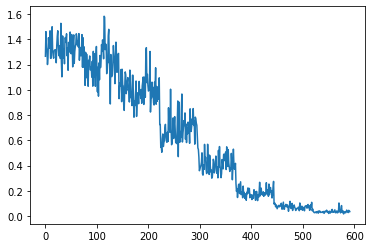

In [23]:
run.recorder.plot_loss()


Our loss has a step like quality to it. Each epoch the variance appears to be decreasing in 

### Param Groups

Let's compare our model_summary to the `grad_params()` method of our Optimizer:

In [40]:
model_summary(run, learn, data)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Output:torch.Size([256, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Output:torch.Size([256, 32, 64, 64])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Output:torch.Size([256, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Output:torch.Size([256, 32, 16, 16])

Sequential(
  (0): 

In [28]:
gp = learn.opt.grad_params()

In [29]:
len(gp)

23

Parameter and hyperparameter for the Conv2d layer of the first block:

In [41]:
gp[0][0].shape, gp[0][1]

(torch.Size([16, 3, 3, 3]), {'lr': tensor(0.2009)})

The next layer that has parameters would be the `BatchNorm2d` layer. 

It has two learnable parameters: `mults` ($\gamma$) and `adds` ($\beta$) from the BatchNorm nb:

In [42]:
gp[1]

(Parameter containing:
 tensor([0.6138, 0.9998, 0.9536, 1.1152, 0.8297, 1.1275, 0.9216, 0.8007, 0.7794,
         1.0044, 0.8322, 0.7611, 0.9389, 1.6529, 1.4474, 0.9847],
        device='cuda:0', requires_grad=True),
 {'lr': tensor(0.2009)})

In [43]:
gp[2]

(Parameter containing:
 tensor([ 0.1193,  0.0069, -0.3453,  0.3296,  0.0519,  0.1793,  0.1601, -0.0094,
          0.0768,  0.1556,  0.2296,  0.1877, -0.1660,  0.1395,  0.2107,  0.0453],
        device='cuda:0', requires_grad=True),
 {'lr': tensor(0.2009)})

In [47]:
for p in learn.model[0][2].parameters(): print(p)

Parameter containing:
tensor([0.6138, 0.9998, 0.9536, 1.1152, 0.8297, 1.1275, 0.9216, 0.8007, 0.7794,
        1.0044, 0.8322, 0.7611, 0.9389, 1.6529, 1.4474, 0.9847],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.1193,  0.0069, -0.3453,  0.3296,  0.0519,  0.1793,  0.1601, -0.0094,
         0.0768,  0.1556,  0.2296,  0.1877, -0.1660,  0.1395,  0.2107,  0.0453],
       device='cuda:0', requires_grad=True)


## Regularization

Now that we have SGD let's add some regularization. 

### L2 Regularization

L2 regularization is a penalty term added to the loss in order to minimize the weights. 

It's generally $\lambda$ (the L2 parameter) multiplied by the sum of the weights squared:

``` python
loss_with_L2 = loss + L2 * (weights**2).sum()
```

It is computationally inefficient to square and sum the weights for each batch and then add them to the loss and compute the gradients. 

Instead we can take the gradient of the weights and multiple it by a *weight decay* parameter `wd` (`L2` above) and add that to the gradient. 


These two equations are equivalent:

``` python
loss_with_L2 = loss + (L2) * (weights**2).sum()
```

``` python
weight.grad += wd * weight
```

Full update looks like this:

``` python
new_weight = weight - lr * (weight.grad + wd * weight)
```


We'll make a `l2_reg` stepper which uses the computationally more efficient way of adding the gradients times the `wd` parameter to the weight gradients:

In [49]:
#export
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data) # scalar times parameter and then add to gradient 
    return p

l2_reg._defaults = dict(wd=0.)

### Weight Decay

If we factor this further:

``` python

new_weight = weight - (lr * weight.grad) - (lr * wd * weight)
```

When we decay each weight by a factor `lr * wd`, it's called **weight decay**


The `weight_decay` stepper will be applied before the `sgd_step`:

``` python

def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p
```

Therefore, all the `weight_decay` stepper needs to do is subtract `lr * wd * weights` from the weights. 

``` python
new_weight = weights - lr * wd * weights

new_weight = weights * (1-lr*wd)
```

Or multiple the weights by `1-lr*wd`



In [50]:
#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd) 
    return p

weight_decay._defaults = dict(wd=0.)

[Decoupled Weight Regularization](https://arxiv.org/pdf/1711.05101.pdf) by Ilya Loshchilov and Frank Hutter, it is better to use the second one with the Adam optimizer.

### Optimizer class v2

Our next optimizer is nearly identical to the first but add in a function to collect the defaults of the steppers to the `self.hyper` list of default hyperparameter dictionaries

In [52]:
#export
def get_defaults(d):
    return getattr(d, "_defaults", {})

In [53]:
get_defaults(sgd_step)

{}

In [54]:
#export
def maybe_update(steppers, dest, func):
    for s in steppers:
        for k,v in func(s).items():
            if not k in dest: dest[k] = v

In [55]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers) # add stepper functions
        maybe_update(self.steppers, defaults, get_defaults) # get defaults
        self.param_groups = list(params) 
        if not isinstance(self.param_groups[0], list): 
            self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups] # make dict of hyper
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers) 
                for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
    
    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

### Weight Decay Test

In [56]:
#export
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [57]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.3, cbs=callbacks, opt_func=sgd_opt)

Check defaults:

In [58]:
model = learn.model

In [59]:
opt = sgd_opt(model.parameters(), lr=0.1)
test_eq(opt.hypers[0]['wd'], 0.)
test_eq(opt.hypers[0]['lr'], 0.1)

It works as expected. 

If we change the default `wd` to `1e-4` its the value we find in the opt.hypers

In [60]:
opt = sgd_opt(model.parameters(), lr=0.1, wd=1e-4)
test_eq(opt.hypers[0]['wd'], 1e-4)
test_eq(opt.hypers[0]['lr'], 0.1)

Now we'll train with Weight Decay:

In [61]:
callbacks = [partial(AvgStatsCallback,accuracy), CudaCallback, 
             partial(BatchTransformXCallback, norm_imagenette), 
            Recorder, partial(ParamScheduler, 'lr', sched)]

Small weight decay of 0.0001

In [70]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.3, cbs=callbacks, opt_func=partial(sgd_opt, wd=1e-4))

In [71]:
run.fit(8, learn)

Train: [1.7847, 0.3846]
Valid: [1.6144, 0.4507]

Train: [1.4308, 0.5202]
Valid: [1.5701, 0.4843]

Train: [1.2488, 0.5856]
Valid: [1.6436, 0.4943]

Train: [1.0398, 0.6558]
Valid: [1.4036, 0.5518]

Train: [0.5838, 0.8178]
Valid: [1.1246, 0.6456]

Train: [0.4596, 0.8598]
Valid: [1.3878, 0.5931]

Train: [0.5138, 0.8323]
Valid: [1.5332, 0.5682]

Train: [0.5362, 0.8231]
Valid: [1.7157, 0.5689]



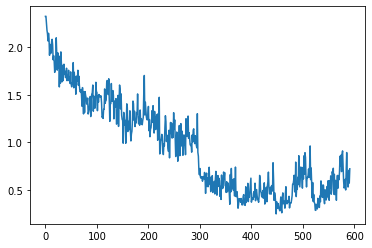

In [72]:
run.recorder.plot_loss()

Its interesting that after epoch 5 the validation loss starts fluctuating and increasing. 


Now let's try a larger weight decay of 0.01

In [73]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.3, cbs=callbacks, opt_func=partial(sgd_opt, wd=0.01))
run.fit(8, learn)

Train: [1.8234, 0.3618]
Valid: [1.84, 0.3901]

Train: [1.4833, 0.503]
Valid: [1.7285, 0.4168]

Train: [1.392, 0.5406]
Valid: [1.547, 0.4927]

Train: [1.2592, 0.5909]
Valid: [1.5746, 0.4741]

Train: [0.9228, 0.7161]
Valid: [1.3172, 0.5618]

Train: [0.9599, 0.6922]
Valid: [1.7325, 0.4446]

Train: [1.122, 0.6447]
Valid: [1.5807, 0.4734]

Train: [1.116, 0.6408]
Valid: [1.6423, 0.4578]



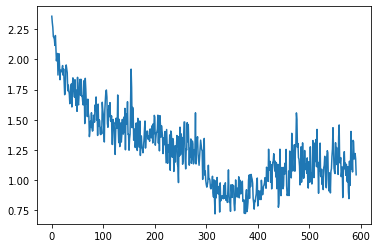

In [74]:
run.recorder.plot_loss()

## Momentum

Momentum helps to accelerate SGD and dampen oscillations.

The update is pretty simple:

$$\begin{align} 
\begin{split} 
v_t &= \gamma v_{t-1} + \eta \nabla_\theta J( \theta) \\ 
\theta &= \theta - v_t 
\end{split} 
\end{align}$$



For momentum we need our Optimizer to be able to hold a state - namely, the exponentially decaying average of the gradients.

In [68]:
#export
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for p, hyper in self.grad_params():
            if p not in self.state:
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats:
                state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

`Stat` abstract base class: two methods need to be implemented by user. 

In [69]:
#export
class Stat():
    _defaults = {}
    def init_state(self, p): 
        raise NotImplementedError
    def update(self, p, state, **kwargs):
        raise NotImplementedError

`AverageGrad` stat:

In [75]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    def init_state(self, p):
        return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

Momentum step:

In [76]:
#export
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

In [77]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step, weight_decay], stats=AverageGrad(), wd=0.01)

Momemtum with normalized batches:

In [78]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.3, cbs=callbacks, opt_func=sgd_mom_opt)
run.fit(1, learn)

Train: [2.1856, 0.2856]
Valid: [1.9288, 0.3218]



And without normalized batches:

In [79]:
callbacks = [partial(AvgStatsCallback,accuracy), CudaCallback, 
            Recorder, partial(ParamScheduler, 'lr', sched)]

In [80]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.3, cbs=callbacks, opt_func=sgd_mom_opt)
run.fit(1, learn)

Train: [2.0915, 0.3169]
Valid: [1.9612, 0.3363]



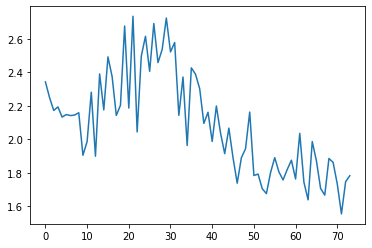

In [81]:
run.recorder.plot_loss()

### Momentum experiments

In order to understand what momentum does to our gradients, let's start by creating some fake data and plotting some simple calculations.

`y` will be a tensor of 200 elements with a mean of 0.3

In [82]:
y = torch.randn(200) + 0.3 

`betas` is an array of 4 numbers between 0.5 and 0.99 we'll use for our beta value

In [83]:
betas = [0.5, 0.7, 0.9, 0.99]

And by plotting our y we can see how they are spread out. 

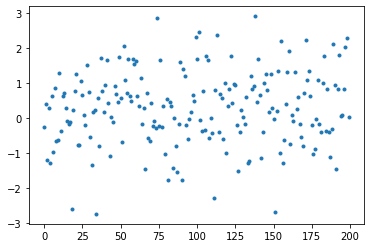

In [84]:
plt.plot(y, linestyle='None', marker='.');

`plot_mom` will create a figure with 4 subplots that each calculates a function given a beta value, an `avg` which it will find, an element from `y` and a `y` index number.

In [85]:
def plot_mom(f):
    # create 4 subplots
    _, axs = plt.subplots(2,2, figsize=(12, 8)) 
    
    # for each subplot plot y and some res calculated by f
    for beta, ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg = None
        res = []
        for i, yi in enumerate(y):
            avg, p = f(avg, beta, yi, i) 
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

#### Regular momentum 

Just add a fraction ($\beta$) of the average to the output:

In [86]:
def mom1(avg, beta, yi, i):
    if avg is None: avg=yi
    res = beta*avg + yi
    return res, res

As the beta term increases, more and more of the average is added to the output. 

As this happens the scale of the output diverges from the data we're attempting to map to.

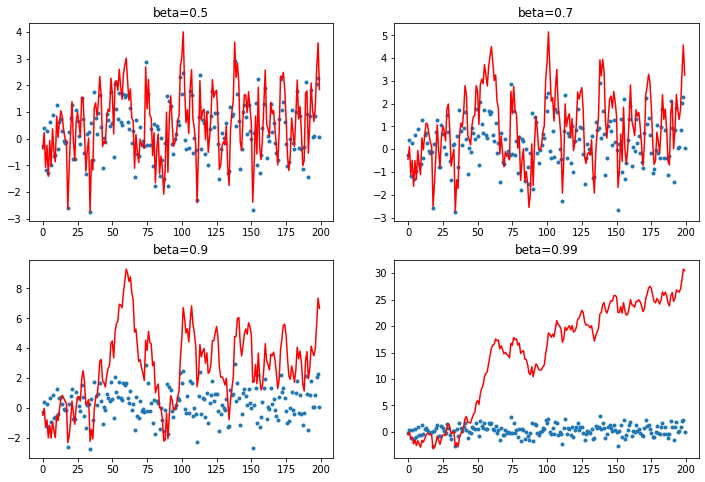

In [87]:
plot_mom(mom1)

When the `beta` term is too high we end up adding too much of the avg and our prediction shoots off - this can happen in training.

#### EWMA Momentum

Instead of just taking the average, let's add a mixture of the previous signal and the current signal using an exponentially weighted moving average.


$$ S_i = \beta S_{i-1} + (\beta -1)x_i$$

In [88]:
def lin_comb(beta, s, x):
    return beta*s + (1-beta)*x

In [89]:
def mom2(avg, beta, yi, i):
    if avg is None: avg=yi
    res = lin_comb(beta, avg, yi)
    return res, res

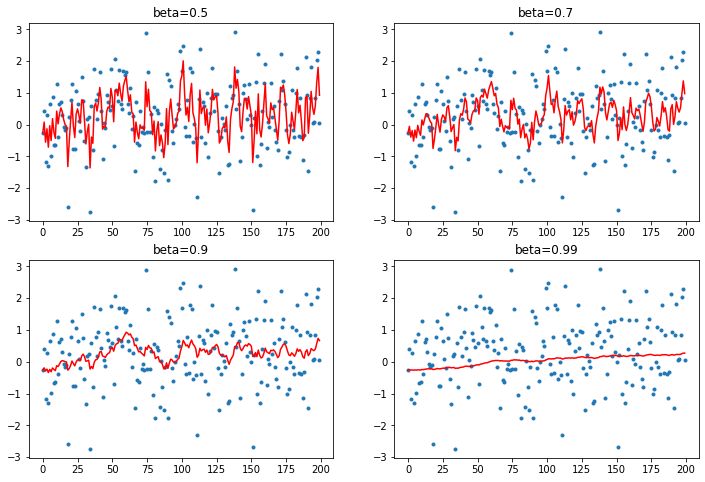

In [90]:
plot_mom(mom2)

#### Mapping to function

Let's turn out `y` into a quadratic.

`x` is 200 evenly spaced numbers between -4 and 4

In [91]:
x = torch.linspace(-4, 4, 200)

We'll subtract 1 to flip the parabola. Divide by 3 to scale it. Add some random noise with a mean of 0.1

In [92]:
y = 1 - (x/3)**2 + torch.randn(200) * 0.1

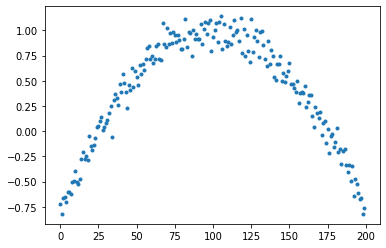

In [93]:
plt.plot(y, linestyle='None', marker='.');

Now let's change the first term to be an outlier of 0.5. This will demonstrate how the EWMA is deformed by the first batch.

In [94]:
y[0] = 0.5

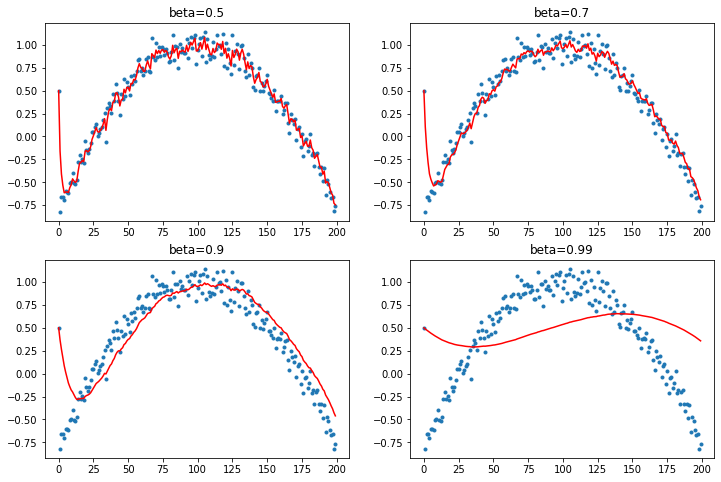

In [95]:
plot_mom(mom2)

The first element biases the prediction, especially when the `beta` value is higher like 0.99. Too much of momentum's influence comes from this EWMA and if the first terms are off then it struggles to recover a good fit.

And when the `beta` term is 0.9 the average is running behind - because momentum is adding the past steps to calculate where it should be going as the data moves in a direction it is slow to adjust. 

__Debiasing__

We would like to correct this tendency of Momentum to get thrown off because of the early data. 

So we'll divide the average by a debiasing terms that corresponds to the sum of the coefficients in our moving average. 

In [96]:
def mom3(avg, beta, yi, i):
    if avg is None: avg=0
    avg = lin_comb(beta, avg, yi)
    return avg, avg/(1-beta**(i+1))

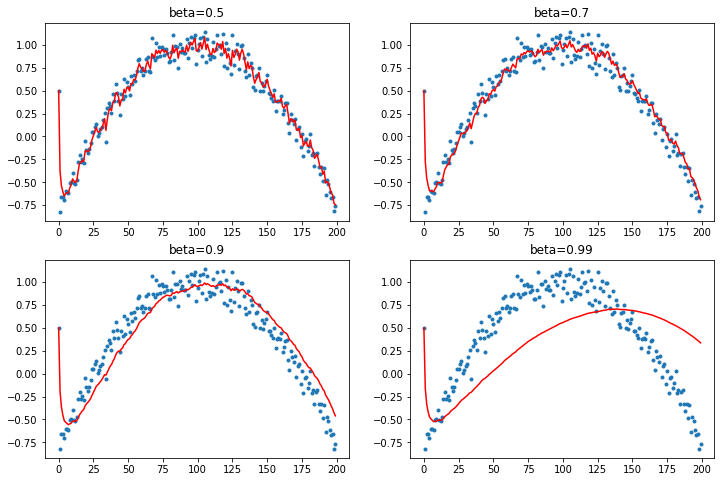

In [97]:
plot_mom(mom3)

## Adam

Adaptive Moment Estimation from the paper: <a href="https://arxiv.org/abs/1412.6980">Adam: A Method for Stochastic Optimization</a>

Adam stores two moving averages:

1. The exponentially decaying average of the past gradients, like momentum (mean, first moment).


$$ m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t $$


2. The exponentially decaying average of the past squared gradients (variance, the second moment).


$$ v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 $$


And then to debias these:

$$\begin{align} 
\begin{split} 
\hat{m}_t &= \dfrac{m_t}{1 - \beta^t_1} \\ 
\hat{v}_t &= \dfrac{v_t}{1 - \beta^t_2} \end{split} 
\end{align}$$


The update rule is as follows:

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

### Adam Stats:

In order to compute $m_t$ above we need an `AverageGrad` stat

In [98]:
#export
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening: bool=False):
        self.dampening = dampening
        
    def init_state(self, p):
        return {'grad_avg': torch.zeros_like(p.grad.data)}
    
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state

And the compute $v_t$ we need an `AverageSqrGrad`

In [99]:
#export
class AverageSqrGrad(Stat):
    _defaults = dict(mom=0.99)
    
    def __init__(self, dampening: bool=False):
        self.dampening = dampening
        
    def init_state(self, p):
        return {'sqr_avg': torch.zeros_like(p.grad.data)}
    
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

And a `StepCount` stat:

In [100]:
#export
class StepCount(Stat):
    def init_state(self, p):
        return {'step': 0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

### Adam Step

Debiasing:

$$ \begin{align} 
\begin{split} 
\hat{m}_t &= \dfrac{m_t}{1 - \beta^t_1} \\ 
\hat{v}_t &= \dfrac{v_t}{1 - \beta^t_2} \end{split} 
\end{align}$$

In [101]:
#export
def debias(mom, damp, step):
    return damp * (1-mom**step) / (1-mom)

Adam step calculates the debiased exponentially decaying averages and it is just the update rule above:


$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

$$ \text{p.data}_i = \text{p.data}_i + -\text{lr} \times \frac{\text{tensor1}_i}{\text{tensor2}_i}$$

In [103]:
#export
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(    mom, mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr/debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p

adam_step._defaults = dict(eps=1e-5)

In [104]:
#export
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, 
                  steppers=[adam_step, weight_decay] + listify(xtra_step),
                  stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()],
                  **kwargs)

In [105]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.001, cbs=callbacks, opt_func=adam_opt())

In [106]:
run.fit(3, learn)

Train: [2.3569, 0.0781]
Valid: [2.3078, 0.1001]

Train: [2.2974, 0.125]
Valid: [2.305, 0.1004]

Train: [2.3116, 0.1094]
Valid: [2.3042, 0.1017]



## Lamb

In [ ]:
nb_auto_export()